loading data and data flattening :
--------------------------------------------

In [1]:
from sklearn.svm import SVC, LinearSVC

import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ProjectedGradientDescent

from art.utils import load_mnist
from joblib import dump, load
%load_ext autoreload
%autoreload 2
from utils import model_performance
# import warnings
# warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/art/estimators/certification/__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

In [3]:
#data seperation to samples and features
n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3] #this gives an output of features 28*28*1= 784

n_samples_test = x_test.shape[0]
n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

#data flattening which gives the output of (number of samples, 784 features)
x_train = x_train.reshape(n_samples_train, n_features_train)
x_test = x_test.reshape(n_samples_test, n_features_test)

#data flattening using argmax to get the label value 
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [4]:
#taking only zero's 

x_train_zero = x_train[y_train == 0]
y_train_zero = y_train[y_train == 0]


y_test_zero =  y_test[y_test == 0]
x_test_zero = x_test[y_test == 0]

In [5]:
#taking only one's 

x_train_one = x_train[y_train == 1]
y_train_one = y_train[y_train == 1]


y_test_one =  y_test[y_test == 1]
x_test_one = x_test[y_test == 1]

In [6]:
y_test_one

array([1, 1, 1, ..., 1, 1, 1])

In [7]:
#maxing the samples to experiment

n_samples_max = 5000
x_train_zero_5=x_train_zero[0:n_samples_max]
y_train_zero_5=y_train_zero[0:n_samples_max]

y_test_zero_5=y_test_zero[0:n_samples_max]
x_test_zero_5=x_test_zero[0:n_samples_max]

In [8]:
x_train_one_5=x_train_one[0:n_samples_max]
y_train_one_5=y_train_one[0:n_samples_max]

y_test_one_5=y_test_one[0:n_samples_max]
x_test_one_5=x_test_one[0:n_samples_max]

In [9]:
x_train_one_5.shape

(5000, 784)

In [10]:
#binary data:

x_train_binary= np.concatenate((x_train_zero, x_train_one))
y_train_binary= np.concatenate((y_train_zero, y_train_one))

x_test_binary= np.concatenate((x_test_zero, x_test_one))
y_test_binary= np.concatenate((y_test_zero, y_test_one))

In [11]:
np.unique(y_train_binary, return_counts=True)

(array([0, 1]), array([5923, 6742]))

Train the classifier and fit only on binary classes: 
--------------------------------------------------

In [12]:
#model = SVC(C=1.0, kernel='linear', probability=True)
# #since we have to only fit on binary training data.
#model.fit(x_train_binary,y_train_binary)
#dump(model, 'binary_model.joblib')

In [13]:
# #since we have to only fit on binary training data.
# model.fit(x_train_binary,y_train_binary)
# dump(model, 'binary_model.joblib')

In [14]:
model = load('binary_model.joblib')
model

SVC(kernel='linear', probability=True)

In [15]:
art_classifier = SklearnClassifier(model=model)

Targetted PGD attack on training:
---------------------------------

In [16]:
pgd = ProjectedGradientDescent(estimator=art_classifier, norm=np.inf, eps=2.0, eps_step=0.3, max_iter=40, 
                               targeted=True, num_random_init=3, batch_size=128, verbose=False)

In [17]:
y_train_target = np.zeros((y_train_zero_5.shape[0], 2)) #only using 2 classes 
y_train_target[:,1] = 1


In [18]:
y_train_target[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [19]:
#x_train_adv = pgd.generate(x_train_zero_5, y=y_train_target)
#dump(x_train_adv, 'training_5k_advsamples.joblib')

In [20]:
x_train_adv= load('training_5k_advsamples.joblib')
x_train_adv.shape

(5000, 784)

In [21]:
# this is the performance on the samples before they are perturbed
y_preds_benign=model.predict(x_train_zero_5)
np.unique(y_preds_benign, return_counts=True)

(array([0]), array([5000]))

In [22]:
# this is the performance on the adversarial samples
y_preds_adv=model.predict(x_train_adv)
np.unique(y_preds_adv, return_counts=True)

(array([1]), array([5000]))

In [23]:
from sklearn.metrics import f1_score,precision_score,recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [24]:
model_performance(y_train_zero_5, y_preds_benign, attack=False, target_label=0)

 attack: False -- recall  1.000
 attack: False -- f1score  1.000
 attack: False -- accuracy  1.000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1386: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1386: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [25]:
model_performance(y_train_zero_5, y_preds_adv, attack=True, target_label=0)

 attack: True -- recall  0.000
 attack: True -- f1score  0.000
 attack: True -- accuracy  0.000
 attack success rate: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1386: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1386: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Tagetted attack on testing data:
----------------------------------------

In [26]:
y_test_target = np.zeros((y_test_zero_5.shape[0], 2))
y_test_target[:,1] = 1


In [27]:
y_test_zero_5.shape

(980,)

In [28]:
#x_test_adv = pgd.generate(x_test_zero_5, y=y_train_target)
#dump(x_test_adv, 'testing_5k_advsamples.joblib')

In [29]:
x_test_adv = load('testing_5k_advsamples.joblib')

In [30]:
# this is the performance on the samples before they are perturbed

y_preds_test_benign=model.predict(x_test_zero_5)
np.unique(y_preds_test_benign, return_counts=True)

(array([0, 1]), array([979,   1]))

In [31]:
# this is the performance on the adversarial samples
y_preds_test_adv=model.predict(x_test_adv)
np.unique(y_preds_adv, return_counts=True)

(array([1]), array([5000]))

In [32]:
model_performance(y_test_zero_5, y_preds_test_benign, attack=False, target_label=0)
print()
print()
model_performance(y_test_zero_5, y_preds_test_adv, attack=True, target_label=0)

 attack: False -- recall  0.499
 attack: False -- f1score  0.500
 attack: False -- accuracy  0.999


 attack: True -- recall  0.000
 attack: True -- f1score  0.000
 attack: True -- accuracy  0.000
 attack success rate: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1386: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1386: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1386: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use l

SELECTING SUCCESFUL SAMPLES:
---------------------------------

In [33]:
import pandas as pd 


In [34]:
succ_adv_samples=x_test_adv[(y_preds_test_adv == 1) & (y_preds_test_benign== 0)]
succ_adv_samples=pd.DataFrame(succ_adv_samples)#successful samples with index values 

In [35]:
succ_adv_samples.shape

(979, 784)

Introducing MPD:
-----------------------

In [36]:
from MPD import MPD
from sklearn.tree import DecisionTreeClassifier

In [37]:
#mpd = MPD(x_train_binary, y_train_binary, DecisionTreeClassifier(), num_bootstrap=100) #training only on 2 classes 
#dump(mpd, 'binary_mpd_dtc.joblib') 


In [38]:
mpd=load('binary_mpd_dtc.joblib')

In [39]:
y_test_zero.shape

(980,)

In [40]:
succ_adv_samples=succ_adv_samples[:450]
succ_adv_samples.shape

(450, 784)

MPD before attack:
--------------------

In [41]:
# no attack
mpd_scores_no_attack = mpd.get_mpd_score(x_test_zero_5)
mpd_scores_no_attack[:5]

array([0., 0., 0., 0., 0.])

In [42]:
# 5000 ones and 450 other zeroes and  450 adversarial samples 
x_test_one_5=x_test_one[0:5000]
y_test_one_5=y_test_one[0:5000]

x_test_zero_last450=x_test_zero[-450:]
y_test_zero_last450=y_test_zero[-450:]

x_test_zero_first450=x_test_zero[:450]
y_test_zero_first450=y_test_zero[:450]

In [43]:
# adversarial testbed

x_adv_testbed= np.concatenate((x_test_one_5, x_test_zero_last450, succ_adv_samples))
x_adv_testbed.shape

(2035, 784)

In [44]:
y_test_one.shape

(1135,)

In [45]:
#concatenating all non adv samples and here y_test_zero_200 will be updated
y_testbed=np.concatenate((y_test_one_5, y_test_zero_last450, y_test_zero_first450))
y_testbed[:-450]=0
y_testbed[-450:] =1
np.unique(y_testbed, return_counts=True)

(array([0, 1]), array([1585,  450]))

In [46]:
#mpd scores after attack

mpd_scores_attack = mpd.get_mpd_score(x_adv_testbed)
mpd_scores_attack.shape

(2035,)

In [47]:
#threshold value 
thvalues = np.linspace(0.01, 0.77, 77)
thvalues

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77])

In [48]:
mpd_scores_attack.shape

(2035,)

In [49]:
y_testbed.shape

(2035,)

In [50]:
from sklearn.metrics import f1_score,precision_score,recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [51]:
score_list=pd.DataFrame(columns=["Threshold_value","TP","FN","FP","TN", "recall", 'f1_score', 'accuracy'])

for idx, t in enumerate(thvalues) :
    mpd_preds = (mpd_scores_attack>t).astype(int)
    
    #print(f"the threshold value is {j} and the mpd predicted label is {mpd_preds[:5]}")
    cmvalues= (confusion_matrix(y_testbed, mpd_preds).ravel()).tolist()
    values=[t.tolist(),]
    values.extend(cmvalues)
    values.append(recall_score(y_testbed,mpd_preds))  
    values.append(f1_score(y_testbed,mpd_preds))
    values.append(accuracy_score(y_testbed,mpd_preds))


    score_list.loc[idx] = values  

In [52]:
score_list

,Threshold_value,TP,FN,FP,TN,recall,f1_score,accuracy
0,0.01,1547.0,38.0,0.0,450.0,1.0,0.959488,0.981327
1,0.02,1547.0,38.0,0.0,450.0,1.0,0.959488,0.981327
2,0.03,1547.0,38.0,0.0,450.0,1.0,0.959488,0.981327
3,0.04,1547.0,38.0,0.0,450.0,1.0,0.959488,0.981327
4,0.05,1547.0,38.0,0.0,450.0,1.0,0.959488,0.981327
...,...,...,...,...,...,...,...,...
72,0.73,1585.0,0.0,450.0,0.0,0.0,0.000000,0.778870
73,0.74,1585.0,0.0,450.0,0.0,0.0,0.000000,0.778870
74,0.75,1585.0,0.0,450.0,0.0,0.0,0.000000,0.778870
75,0.76,1585.0,0.0,450.0,0.0,0.0,0.000000,0.778870


In [53]:
score_list.describe()

,Threshold_value,TP,FN,FP,TN,recall,f1_score,accuracy
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.390000,1569.961039,15.038961,321.428571,128.571429,0.285714,0.275846,0.834660
std,0.223719,12.323962,12.323962,204.622337,204.622337,0.454716,0.439021,0.095215
min,0.010000,1547.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.768059
25%,0.200000,1559.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.773464
50%,0.390000,1573.000000,12.000000,450.000000,0.000000,0.000000,0.000000,0.776413
75%,0.580000,1580.000000,26.000000,450.000000,450.000000,1.000000,0.959488,0.981327
max,0.770000,1585.000000,38.000000,450.000000,450.000000,1.000000,0.971922,0.987224


In [54]:
score_list.f1_score.max()

0.9719222462203023

In [55]:
tvalue = score_list[score_list.f1_score==score_list.f1_score.max()]
tvalue

,Threshold_value,TP,FN,FP,TN,recall,f1_score,accuracy
19,0.20,1559.0,26.0,0.0,450.0,1.0,0.971922,0.987224
20,0.21,1559.0,26.0,0.0,450.0,1.0,0.971922,0.987224
21,0.22,1559.0,26.0,0.0,450.0,1.0,0.971922,0.987224


In [56]:
#taking the best threshold value which is max of f1 score 0.0098
best_t = tvalue.Threshold_value.values[0]
mpd_pred1 = mpd_scores_attack.copy()
mpd_pred1[mpd_pred1 > best_t ] = 1
mpd_pred1[mpd_pred1 <= best_t] = 0

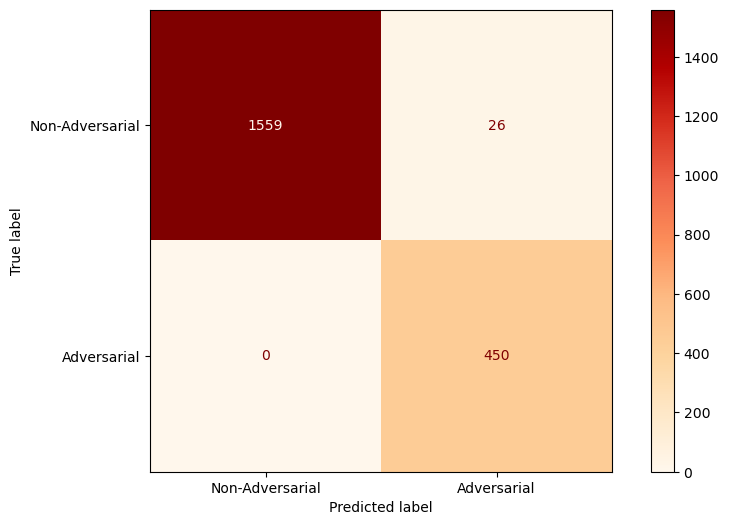

In [57]:
c = ConfusionMatrixDisplay(confusion_matrix(y_testbed,mpd_pred1), display_labels=['Non-Adversarial','Adversarial'])
fig, ax = plt.subplots(figsize=(10,6))
plt.grid(False)
c.plot(ax = ax, cmap='OrRd', xticks_rotation = 0,values_format='d')

In [59]:
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(0.0, 500.0)

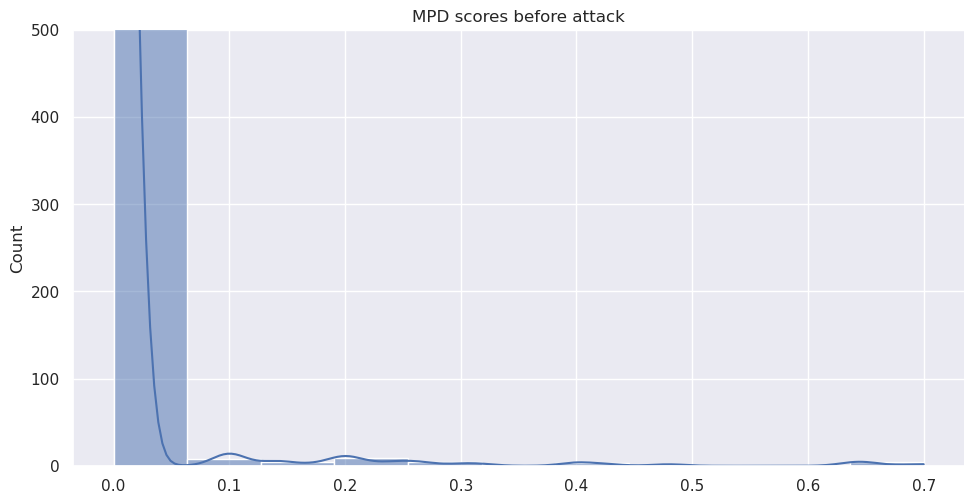

In [60]:
sns.displot(mpd_scores_no_attack, kde = True, aspect = 2)
plt.title("MPD scores before attack")
plt.ylim(0,500)

(0.0, 500.0)

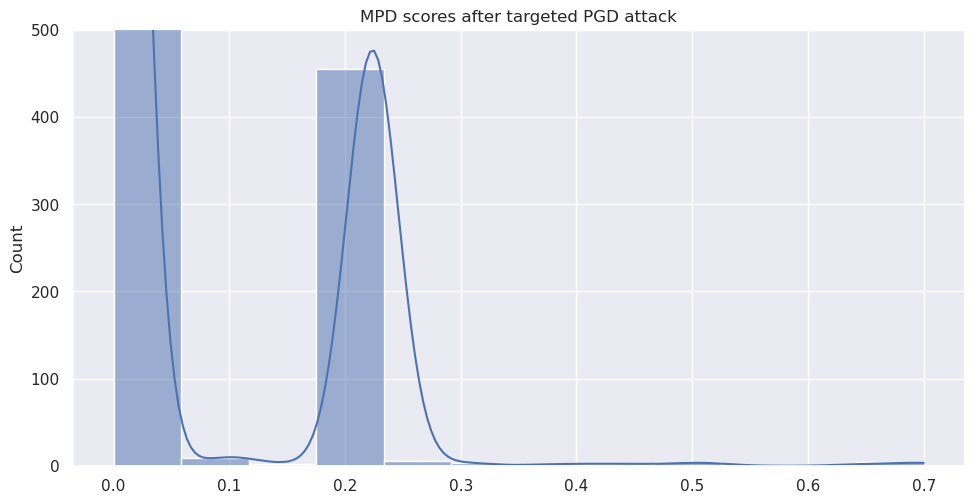

In [61]:
sns.displot(mpd_scores_attack, kde = True, aspect = 2)
plt.title("MPD scores after targeted PGD attack")
plt.ylim(0,500)

In [67]:
fp_predit = model.predict(fp)
fp_predit

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0])

In [68]:
 ### FP Drilldown
fp_f1 = f1_score(fp_ytest, fp_predit)
fp_recall = recall_score(fp_ytest, fp_predit)
fp_precision = precision_score(fp_ytest, fp_predit)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
fp_accuracy = accuracy_score(fp_ytest, fp_predit)
fp_accuracy

0.3076923076923077

In [70]:
fp_success=1-fp_accuracy
fp_success

0.6923076923076923